In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [198]:
df = pd.read_csv('data.csv')
df = df.drop(columns = ['Unnamed: 0', 'Photo','Flag','Club Logo','Loaned From','LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW','LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM','CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB','Release Clause','Joined','Contract Valid Until','ID','Real Face','Jersey Number'])

I decided to drop these columns because they did not add any significant value to my analysis (like flag and photo).

In [200]:
worth = df['Value']
worth = worth.tolist()
worth1 = []
for value in worth:
    value = value[1::]
    worth1.append(value)
worth2 = []
for value in worth1:
    if value[-1] == 'K':
        value = float(value[:-1:])*1000
        worth2.append(value)
    elif value[-1] == 'M':
        value = float(value[:-1:])*1000000
        worth2.append(value)
    else:
        worth2.append(int(value))
df['Value Integer'] = worth2
df = df.drop(columns = ['Value'])

I wanted to have as my dependent variable the value of the player, but I soon encountered an issue: the euro sign and M (designating millions) or K (designating thousands) were also present, making the value a string, not an integer. As a result, I decided to go through each value and first get rid of the euro designation, appending these strings to a new list. Then, I had to change the abbrevations of millions (M) and thousands (K) into numerical values, so I used a simple for loop and conditional statements. Thus, the transformation into integers was complete. I used a similar process for wage.

In [203]:
wage = df['Wage']
wage = wage.tolist()
wage1 = []
for salary in wage:
    salary = salary[1::]
    wage1.append(salary)
wage2 = []
for salary in wage1:
    if salary[-1] == 'K':
        salary = float(salary[:-1:])*1000
        wage2.append(salary)
    elif salary[-1] == 'M':
        salary = float(salary[:-1:])*1000000
        wage2.append(salary)
    else:
        wage2.append(float(salary))
df['Wage Integer'] = wage2
df = df.drop(columns = ['Wage'])

In [204]:
df = df.dropna(subset = ['Height','Weight'])
height = df['Height']
height = height.tolist()
height1 = []
for tall in height:
    tall = int(tall[0])*12+int(tall[2::])
    height1.append(tall)
df['Height Integer'] = height1
df = df.drop(columns = ['Height'])
weight = df['Weight']
weight = weight.tolist()
weight1 = []
for heavy in weight:
    heavy = int(heavy[0:3:])
    weight1.append(heavy)
df['Weight Integer'] = weight1
df = df.drop(columns = ['Weight'])

Height and weight had a similar problem to value and wage, as height was written with apostrophes (such as 5'7) and weight had lbs at the end, and so I used a similar solution.

In [205]:
df = df[df['Value Integer'] != 0]
df = df[df['Wage Integer'] != 0]

After I sns.pairplotted value and wage (below), I saw I needed to log these two columns, but many values were equal to 0 (which, when logged, would result in negative infinity). I decided to simply drop all the rows which had value or wage as 0, as this value was most likely inserted as a placeholder and not because a player is worth/makes nothing.

In [209]:
one_hot = pd.get_dummies(df['Nationality'])
new_df = df.drop(columns = ['Nationality'])
one_hot1 = pd.get_dummies(df['Club'])
new_df = new_df.drop(columns = ['Club'])
one_hot = one_hot.join(one_hot1)
one_hot1 = pd.get_dummies(df['Preferred Foot'])
new_df = new_df.drop(columns = ['Preferred Foot'])
one_hot = one_hot.join(one_hot1)
one_hot1 = pd.get_dummies(df['Work Rate'])
new_df = new_df.drop(columns = ['Work Rate'])
one_hot = one_hot.join(one_hot1)
one_hot1 = pd.get_dummies(df['Position'])
new_df = new_df.drop(columns = ['Position'])
one_hot = one_hot.join(one_hot1)
new_df = new_df.join(one_hot)

I changed all the categorical variables in the dataframe into one_hots. I decided not to use body type as it contained several strange values/placeholders, and, when I one_hotted it and compared it to value, the $R^2$ was very close to 0. I decided to make one massive one_hot as I would need to separate the categorical variables from the numerical ones later on in a pipeline.

In [210]:
new_df.corr()['Value Integer'].sort_values(ascending = False)

Value Integer               1.000000
Wage Integer                0.858037
International Reputation    0.656158
Overall                     0.631673
Potential                   0.579922
Reactions                   0.544993
Composure                   0.454569
Special                     0.380421
Vision                      0.359992
ShortPassing                0.330028
Skill Moves                 0.317246
BallControl                 0.310646
LongPassing                 0.304721
Volleys                     0.290142
Curve                       0.288665
ShotPower                   0.283265
LongShots                   0.281697
Dribbling                   0.273300
FKAccuracy                  0.267530
Positioning                 0.260694
Finishing                   0.258196
Crossing                    0.251626
Penalties                   0.241377
Stamina                     0.212579
Agility                     0.195033
HeadingAccuracy             0.186152
Aggression                  0.186103
R

In [211]:
cor = new_df.corr()
cor_target = abs(cor['Value Integer'])
relevant_features = cor_target[cor_target > 0.35]
new_df_high = new_df[relevant_features.index]

As using all of the categorical variables in new_df would result in over 800 columns, making sns pairplotting impossible, I decided to drop all the variables that had an absolute value of $(R^2)$ less than 0.35, which would allow me to view the relationships between the most important variables.

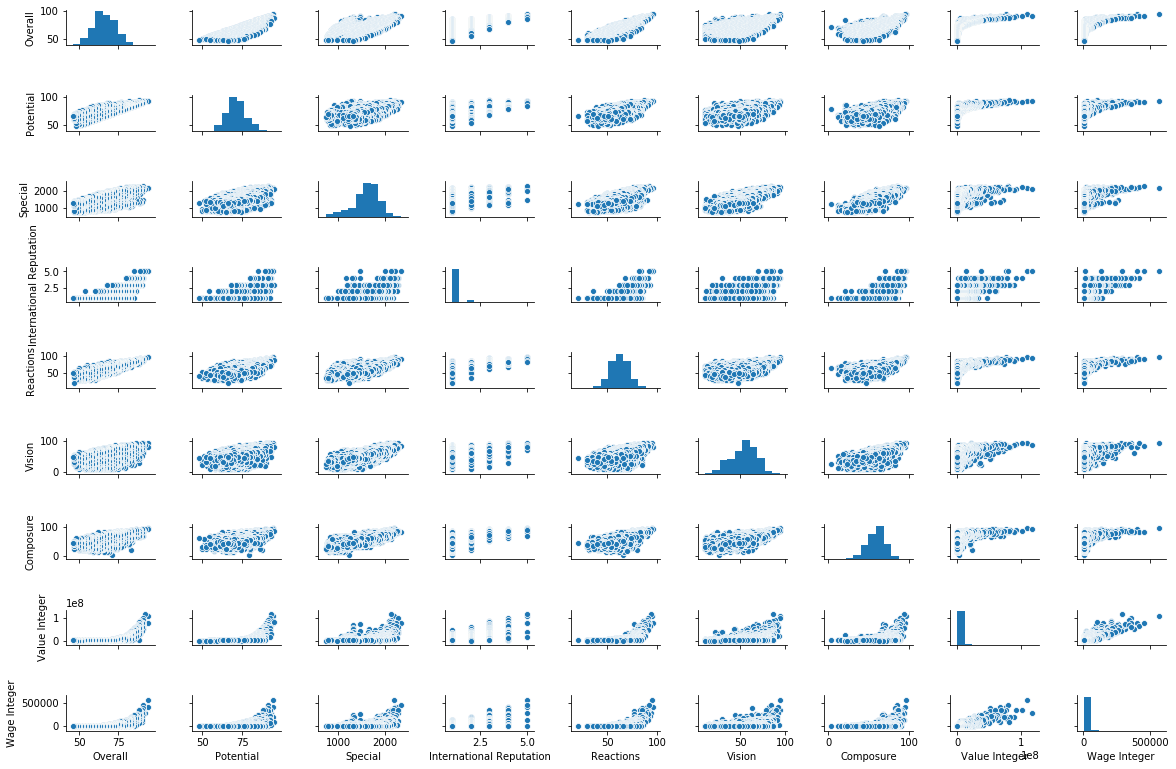

In [220]:
sns.pairplot(new_df_high, height = 1.2, aspect=1.5)

Surprisingly, all of these variables were quite evenly distributed, save for International Reputation, Value, and Wage. I decided to natural log these to see if I could achieve the more even distribution that is required for Ridge Regresssion.

In [123]:
log_new_df_high.loc[:,'log_rep'] = np.log(new_df_high.loc[:,'International Reputation'])
log_new_df_high.loc[:,'log_value'] = np.log(new_df_high.loc[:,'Value Integer'])
log_new_df_high.loc[:,'log_wage'] = np.log(new_df_high.loc[:,'Wage Integer'])
log_new_df_high = new_df_high.drop(columns = ['International Reputation','Value Integer','Wage Integer'])

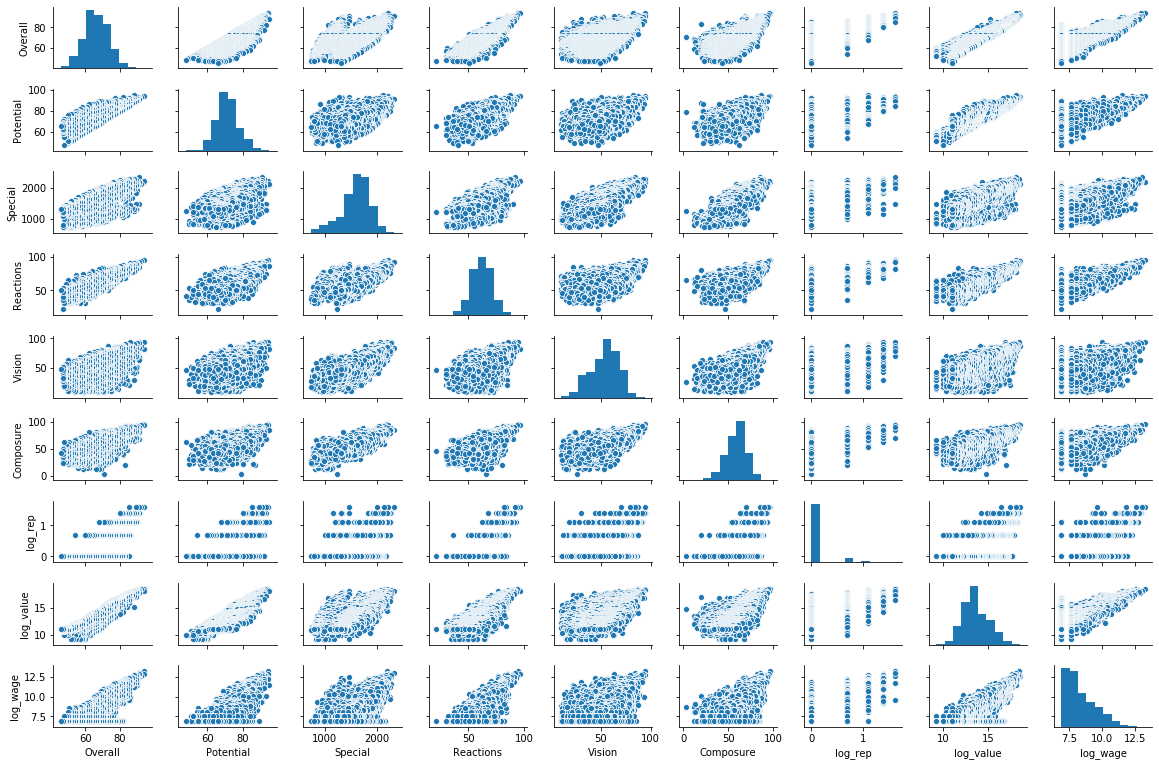

In [124]:
sns.pairplot(log_new_df_high, height = 1.2, aspect = 1.5)

Natural logging these three variables definitely improved the distribution of value and wage, but did little for international reputation, most likely because that is given on an integer scale of 1 to 5, and very few players achieve high fame.

In [61]:
cor = new_df.corr()
cor_target = abs(cor['Value Integer'])
relevant_features = cor_target[(0.1 < cor_target) & (cor_target < 0.35)]
new_df_medium = new_df[relevant_features.index]
new_df_medium = new_df_medium.join(df['Value Integer'])
new_df_medium.corr()['Value Integer'].sort_values(ascending = False)

Value Integer          1.000000
ShortPassing           0.327623
Skill Moves            0.315651
BallControl            0.308818
LongPassing            0.302175
Volleys                0.288243
Curve                  0.287235
ShotPower              0.281360
LongShots              0.279730
Dribbling              0.272004
FKAccuracy             0.265773
Positioning            0.259391
Finishing              0.256665
Crossing               0.249785
Penalties              0.239033
Stamina                0.210721
Agility                0.194259
Aggression             0.184639
HeadingAccuracy        0.184437
Real Madrid            0.183448
FC Barcelona           0.178410
SprintSpeed            0.172677
Juventus               0.170781
Acceleration           0.170603
Weak Foot              0.165221
Manchester City        0.163164
FC Bayern München      0.149938
Interceptions          0.140666
Marking                0.133862
Paris Saint-Germain    0.133836
Atlético Madrid        0.130378
Strength

In [62]:
cor = new_df.corr()
cor_target = abs(cor['Value Integer'])
relevant_features = cor_target[(0.05 < cor_target) & (cor_target < 0.1)]
new_df_low = new_df[relevant_features.index]
new_df_low = new_df_low.join(df['Value Integer'])
new_df_low.corr()['Value Integer'].sort_values(ascending = False)

Value Integer          1.000000
Milan                  0.089757
Spain                  0.088422
SlidingTackle          0.087735
Brazil                 0.085552
Arsenal                0.082239
Borussia Dortmund      0.078604
Age                    0.075147
Valencia CF            0.072598
Roma                   0.070888
FC Porto               0.067140
Bayer 04 Leverkusen    0.066269
Lazio                  0.064421
Portugal               0.063508
SL Benfica             0.063043
Real Betis             0.059371
Olympique Lyonnais     0.059305
Sevilla FC             0.057464
Sporting CP            0.054891
RB Leipzig             0.052635
France                 0.052286
Everton                0.051640
England               -0.051704
China PR              -0.054496
Name: Value Integer, dtype: float64

In [60]:
cor = new_df.corr()
cor_target = abs(cor['Value Integer'])
relevant_features = cor_target[0.05 > cor_target]
new_df_lowest = new_df[relevant_features.index]
new_df_lowest = new_df_lowest.join(df['Value Integer'])
new_df_lowest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18159 entries, 0 to 18206
Columns: 791 entries, GKDiving to Value Integer
dtypes: float64(6), int64(2), uint8(783)
memory usage: 15.4 MB


I split up the rest of the variables into several different sections depending on their $R^2$ value, to be able to easily view $R^2$.

In [217]:
X = df.drop(columns = ['Value Integer','Name','Nationality','Club','Preferred Foot','Work Rate','Body Type','Position'])
Y = df['Value Integer']
def comehome(a):
    a = a.join(one_hot)
model = make_pipeline(StandardScaler(),comehome(X),RidgeCV(cv =10))
model.fit(X,Y)
R = model.score(X,Y)
print(R,(1-((1-R)*(len(Y)-1))/(len(Y)-X.shape[1]-1)))

0.8002395343179898 0.7997474583752058


In [219]:
X = df.drop(columns = ['International Reputation','Wage Integer','Value Integer','Name','Nationality','Club','Preferred Foot','Work Rate','Body Type','Position'])
X.join(log_new_df_high['log_rep'])
X.join(log_new_df_high['log_wage'])
Y = log_new_df_high['log_value']  
model = make_pipeline(StandardScaler(),comehome(X),RidgeCV(cv =10))
model.fit(X,Y)
R = model.score(X,Y)
print(R,(1-((1-R)*(len(Y)-1))/(len(Y)-X.shape[1]-1)))

0.9708498748293883 0.9707813400523414


Here, I made a pipeline, which was initially very complicated as I needed to scale my values but had plenty of categorical columns that made it impossible to do so, and I could not drop them individually because there were over 700 of them. As a result, I definied a function to join the categorical variables to the dataframe after scaling had been applied to the integer columns.

0.4772547718865077 0.9708723602435393


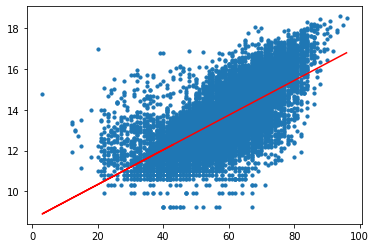

In [295]:
X = log_new_df_high['Composure']
y = log_new_df_high['log_value']
model = LinearRegression()
X = X[:, np.newaxis]
model.fit(X,y)
ypredict = model.predict(X)
plt.scatter(X, y, s=10)
plt.plot(X, ypredict, color='r')
print(model.score(X,y),(1-((1-R)*(len(y)-1))/(len(y)-X.shape[1]-1)))

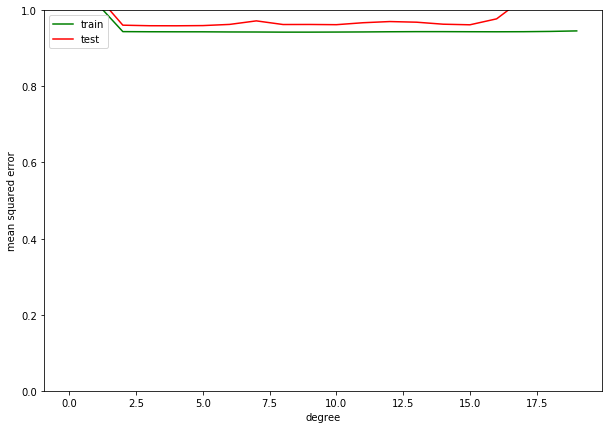

In [296]:
polynomial_features = PolynomialFeatures()
degrees = 20
train_error = []
test_error = []
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size=0.7)
for degree in range(degrees):
    model = make_pipeline(PolynomialFeatures(degree),LinearRegression())
    model.fit(X_train,y_train)
    train_error.append(mean_squared_error(y_train, model.predict(X_train)))
    test_error.append(mean_squared_error(y_test, model.predict(X_test)))
plt.figure(figsize=(10,7))
plt.plot(np.arange(degrees), train_error, color='green', label='train')
plt.plot(np.arange(degrees), test_error, color='red', label='test')
plt.ylim((0.0, 1e0))
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')

In [297]:
for i in range(1,20):
    polynomial_features= PolynomialFeatures(degree=i)
    x_poly = polynomial_features.fit_transform(X)
    model = LinearRegression()
    model.fit(x_poly, y)
    print(i,model.score(x_poly,y))
#first degree is lowest, no need to change

1 0.4772547718865078
2 0.5173406693843001
3 0.518051358858294
4 0.5181041430368527
5 0.5181296965395089
6 0.5183110820710651
7 0.5183747764374798
8 0.5187914544059411
9 0.5188079621344113
10 0.5189037548746089
11 0.5176907777452608
12 0.5172043893694772
13 0.5171307012112255
14 0.5173305088186572
15 0.5175126537872341
16 0.5174363445910861
17 0.5169789391374174
18 0.5161070233620445
19 0.514826618808222


In [292]:
X = df.drop(columns = ['International Reputation','Wage Integer','Value Integer','Name','Nationality','Club','Preferred Foot','Work Rate','Body Type','Position'])
X.join(log_new_df_high['log_rep'])
X.join(log_new_df_high['log_wage'])
Y = log_new_df_high['log_value']
model = make_pipeline(StandardScaler(),comehome(X),RidgeCV(store_cv_values = True))
model.fit(X,Y)
R = model.score(X,Y)
print(f'The R^2 value is: {R} and the adjusted R^2 value is: {1-((1-R)*(len(y)-1))/(len(y)-X.shape[1]-1)}')
print(f'Some of the coefficients are: {model.steps[2][1].coef_}')
print(f'The ideal alpha is: { model.steps[2][1].alpha_}')
print(f'The average mean squared error is: {np.mean(model.steps[2][1].cv_values_, axis=0)[0]}')

The R^2 value is: 0.9708739869407221 and the adjusted R^2 value is: 0.9708055088535922
Some of the coefficients are: [-4.66246513e-01  1.51421202e+00 -2.56309848e-02 -8.90556932e-01
 -1.02390743e-04  2.22655014e-02  2.69075918e-02  8.82952632e-02
  6.83777367e-02  5.20053583e-02  8.44922338e-02  5.58031208e-02
  6.05011533e-02  7.41729590e-02  6.76360839e-02  7.78082912e-03
  4.62238919e-02  5.04184248e-02  4.66902772e-02  4.85375709e-02
  4.40020455e-02  6.00277652e-02  3.58947753e-02  7.02737768e-02
  3.63607061e-02  5.18581280e-02  6.15808501e-02  6.46928187e-02
  8.49559707e-02  6.32681552e-02  6.03281930e-02 -5.17744222e-03
  4.48941056e-02  8.07002785e-02  3.29414581e-02  8.35996021e-02
  3.18963896e-02  3.54215094e-02  2.30715325e-02  5.56695395e-02
  3.72451239e-03 -6.10631306e-04]
The ideal alpha is: 0.1
The average mean squared error is: 0.057980688016890575


In [298]:
X = log_new_df_high.drop(columns = ['log_value'])
Y = log_new_df_high['log_value']
model = make_pipeline(StandardScaler(),comehome(X),RidgeCV(store_cv_values = True))
model.fit(X,Y)
R = model.score(X,Y)
print(f'The R^2 value is: {R} and the adjusted R^2 value is: {1-((1-R)*(len(y)-1))/(len(y)-X.shape[1]-1)}')
print(model.steps[2][1].coef_)
print(f'The ideal alpha is: {model.steps[2][1].alpha_}')
print(f'The average mean squared error is: {np.mean(model.steps[2][1].cv_values_, axis=0)[0]}')

The R^2 value is: 0.9429936546928235 and the adjusted R^2 value is: 0.9429681741496088
[ 0.9427363   0.4202552   0.12572617 -0.03355369  0.03613    -0.04762959
 -0.04355927  0.11289603]
The ideal alpha is: 1.0
The average mean squared error is: 0.11301764764704172


I used both all the values and just the highest correlated values in my model, to show both a complete and most accurate answer and a simplified and more practical equation whose variables almost completely account for the value of a player.

Player value (with only highest correlated variables) = 0.9427363*overall + 0.4202552*potential + 0.12572617*special - 0.03355369*reactions + 0.03613*vision - 0.04762959*composure - 0.04355927*log of reputation + 0.11289603*log of wage

Player value (with all variables) = -4.66246513e-01*age + 1.51421202e+00*overall - 2.56309848e-02*potential +...